## 反激电源计算

### 头文件

In [ ]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import control as ctrl
from scipy.interpolate import interp1d
from sympy import symbols, Eq, solve, I
import json
from pathlib import Path
from json_pre import calculate_expression
from json_pre import load_core_parameters

### 输入参数

In [ ]:
V_IN = 220  # 常规输入电压 (V)
V_AC_MIN = 85  # 最小输入电压 (V)
V_AC_MAX = 265  # 最大输入电压 (V)
V_OUT = 24  # 输出电压 (V)
F_SW = 100e3  # 开关频率 (Hz)
P_OUT = 120  # 输出功率 (W)
EFFICIENCY = 0.85  # 效率
P_IN = P_OUT / EFFICIENCY  # 输入功率 (W)
V_OR = 100 #反射电压 (V)
V_DS = 1.7  # MOSFET 导通电压 (V)
K_RP = 0.8 # 电流脉动系数
V_F = 0.7  # 二极管正向压降 (V)
K_O = 0.4 #反激变压器窗口填充系数
B_W = 0.2 # 变压器的磁通量(T) 通常在0.2-0.4T之间
B_MAX = 0.2 # 变压器的最大磁通密度 (mT)
K_JP = 3.95 # 初级电流密度系数
K_JS = 6 # 次级电流密度系数

### 单相桥式整流滤波电路

In [49]:
V_BUS = V_IN * m.sqrt(2)  # 整流后电压
V_BULK_MIN = V_AC_MIN * m.sqrt(2)  # 最小整流电压
V_BULK_MAX = V_AC_MAX * m.sqrt(2)  # 最大整流电压
I_AC_MAX = P_IN / V_AC_MIN  # 最大输入电流

print("最小整流电压 V_BULK_MIN: %.2f" % V_BULK_MIN)
print("最大整流电压 V_BULK_MAX: %.2f" % V_BULK_MAX)
print("最大输入电流 I_AC_MAX: %.2f" % I_AC_MAX)


最小整流电压 V_BULK_MIN: 120.21
最大整流电压 V_BULK_MAX: 374.77
最大输入电流 I_AC_MAX: 1.66


### 输入电容

In [ ]:
C_in = (2 * P_IN * (0.25 + 1 / np.pi * np.arcsin(75 / m.sqrt(2) / V_AC_MIN))) / (
    (2 * m.pow(V_AC_MIN, 2) - m.pow(75, 2)) * 47
)
print("输入电容 C_in = %.2fuF" % (C_in * 1e6))

输入电容 C_in = 316.18uF


### 变压器

In [ ]:
# 最大占空比计算
D_MAX = V_OR / (V_OR + V_BULK_MIN - V_DS)
print("最大占空比 D_MAX = %.2f" % D_MAX)

# 220V占空比计算
D_NOM = V_OR / (V_OR + V_BUS - V_DS)
print("220V占空比 D_NOM = %.2f" % D_NOM)

# 满载输入平均电流
I_AVG = P_IN / V_BULK_MIN
print("满载输入平均电流 I_AVG = %.2f A" % I_AVG)

# 初级峰值输入电流
I_PPK = I_AVG / ((1 - 0.5 * K_RP) * D_MAX)
print("初级峰值输入电流 I_PPK = %.2f A" % I_PPK)

# 脉动电流
I_RIPPLE = I_PPK * K_RP
print("脉动电流 I_RIPPLE = %.2f A" % I_RIPPLE)

# 初级有效电流
I_PRMS = I_PPK * m.sqrt(D_MAX * (pow(K_RP, 2) / 3 - K_RP + 1))
print("初级有效电流 I_PRMS = %.2f A" % I_PRMS)

# 初级励磁电感
L_P = (P_OUT / (I_PPK * I_PPK * K_RP * (1 - 0.5 * K_RP) * F_SW)) * (
    (0.5 * (1 - EFFICIENCY) + EFFICIENCY) / EFFICIENCY
)
L_P_uH = L_P * 1e6  # 转换为微亨
print("初级励磁电感 L_P = %.2f uH" % L_P_uH)

# 匝数比
N_PS = D_MAX / (1 - D_MAX) * (V_BULK_MIN - V_DS) / (V_OUT + V_F)
print("匝数比 N_PS = %.2f" % N_PS)

# 磁芯AP值
A_P = pow((L_P * I_PPK * I_PPK * 1e2) / (B_W * K_O * K_JS), 1.14)
print("磁芯AP值 A_P = %.4f cm^4" % A_P)

最大占空比 D_MAX = 0.46
220V占空比 D_NOM = 0.24
满载输入平均电流 I_AVG = 1.17 A
初级峰值输入电流 I_PPK = 4.28 A
脉动电流 I_RIPPLE = 3.42 A
初级有效电流 I_PRMS = 1.86 A
初级励磁电感 L_P = 148.72 uH
匝数比 N_PS = 4.05
磁芯AP值 A_P = 0.5235 cm^4


#### 磁芯选择

In [ ]:
# 磁芯参数计算

# 加载参数文件
json_path = Path("BYDZ_EECore.json")
core_data = load_core_parameters(json_path)

Core_Type = "EE40"
params = core_data[Core_Type]

Ae = params["Ae"]  # 磁芯有效截面积 (mm^2)
print(f"磁芯有效截面积 Ae = {Ae:.2f} mm^2")
Aw = params["Aw"]  # 磁芯窗口面积 (mm^2)
print(f"磁芯窗口面积 Aw = {Aw:.4f} mm^2")
AP = Ae * 1e-2 * Aw * 1e-2  # 磁芯有效面积 (cm^4)
print(f"磁芯有效面积 AP = {AP:.4f} cm^4")

if AP <= (2 * A_P):
    raise ValueError(f"磁芯参数不满足：AP={AP:.4f} ≤ 2*A_P={2 * A_P:.4f}")
print(f"磁芯参数满足要求AP={AP:.4f} >= 2*A_P={2 * A_P:.4f}")

磁芯有效截面积 Ae = 144.50 mm^2
磁芯窗口面积 Aw = 165.9000 mm^2
磁芯有效面积 AP = 2.3973 cm^4
磁芯参数满足要求AP=2.3973 >= 2*A_P=1.0470


#### 变压器绕组

In [ ]:
# N_P_0 = (V_BULK_MIN*D_MAX)/(Ae*1e-6*B_MAX*F_SW) # 初级匝数

N_P_0 = (V_BULK_MIN * m.sqrt(D_MAX) * 1e4) / (B_MAX * F_SW * K_RP)  # 初级匝数
# N_P_0 =  23
# print("初级匝数 N_P_0 = %.4f" % N_P_0)
N_S_0 = N_P_0 / N_PS  # 次级匝数
N_S1_0 = N_S_0 * 18 / V_OUT  # 15V辅助绕组匝数

# 实际选取匝数
N_P = m.ceil(N_P_0)  # 初级匝数
N_S = m.ceil(N_S_0)  # 次级匝数
N_S1 = m.ceil(N_S1_0)  # 辅助绕组匝数

V_BIAS = V_OUT * N_S1 / N_S

if V_BIAS < 25:
    print("初级匝数 N_P = %.d" % N_P)
    print("次级匝数 N_S = %.d" % N_S)
    print("辅助绕组匝数 N_S1 = %.d" % N_S1)
else:
    print("匝数选取不合适，请重新计算！")

初级匝数 N_P = 51
次级匝数 N_S = 13
辅助绕组匝数 N_S1 = 10


确定绕组漆包线径

In [33]:
# 趋肤深度计算（经验公式）
D_m = 2 * 66.1e-3 / m.sqrt(F_SW)
print("趋肤深度 D_m = %.4f mm" % (D_m * 1e3))

# 次级峰值电流
I_SPK = I_PPK * N_P / N_S
print("次级峰值电流 I_SPK = %.4f A" % I_SPK)

# 次级有效电流
I_SRMS = I_SPK * m.sqrt((1 - D_MAX) * (pow(K_RP, 2) / 3 - K_RP + 1))
print("次级有效电流 I_SRMS = %.4f A" % I_SRMS)

趋肤深度 D_m = 0.4181 mm
次级峰值电流 I_SPK = 16.7792 A
次级有效电流 I_SRMS = 7.9444 A


选择0.25mm的线，电流密度一般为4~6A/mm^2，初级取4A/mm^2，次级取5A/mm^2

In [34]:
D_p = 0.4  # 初级线圈直径 (mm)
P_p = 2  # 初级线圈并联数
J_p = I_PRMS / ((m.pi * pow(D_p, 2) / 4) * m.pi * P_p)  # 初级线圈电流密度 (A/mm^2)
print("初级线圈电流密度 J_p = %.4f A/mm^2" % J_p)

D_s = 0.4  # 次级线圈直径 (mm)
P_s = 4  # 次级线圈并联数
J_s = I_SRMS / ((m.pi * pow(D_s, 2) / 4) * m.pi * P_s)  # 次级线圈电流密度 (A/mm^2)
print("次级线圈电流密度 J_s = %.4f A/mm^2" % J_s)

初级线圈电流密度 J_p = 2.3560 A/mm^2
次级线圈电流密度 J_s = 5.0309 A/mm^2


在选定变压器原副边绕组后，需核算变压器是否在选定线的绕组时，能否绕制得下，通过计算所有绕组截面积之和与变压器骨架窗口之得占比来判定。计算所有绕组截面积占变压器窗口的系数Kw

In [35]:
K_w = (
    pow(D_p, 2) / 4 * m.pi * P_p * N_P + pow(D_s, 2) / 4 * m.pi * P_s * N_S
) / Aw  # 磁芯窗口填充系数
print("磁芯窗口填充系数 K_w = %.4f" % K_w)

磁芯窗口填充系数 K_w = 0.1166


通常变压器绕组设计时，由于绕组的线具有一定的绝缘层，同时，绕组过程中也会增加绝缘胶带，挡墙等，为了保证绕组能绕下，且具有较好的经济性，窗口系数一般指定在0.1~0.3之间较为合适，作为初学的稳定性考虑，经济性先不作为主要考虑，因此上述计算的窗口系数证明绕组选择相对合理。

### MOSFET

In [ ]:
V_mos = (V_F + V_OUT) * N_P / N_S + V_BULK_MAX
print("MOSFET电压 V_mos = %.2f V" % V_mos)

# 1.5倍裕量
print("MOSFET选定电压应不小于 1.5*V_mos = %.2f V" % (V_mos * 1.5))

MOSFET电压 V_mos = 471.67 V
MOSFET选定电压应不小于 1.5*V_mos = 707.50 V


#### 二极管

In [ ]:
# 计算次级二极管电压
V_dio = V_OUT+ V_BULK_MAX*N_S/N_P
print("次级二极管电压 V_dio = %.2f V" % V_dio)

#1.5倍裕量
print("次级二极管选定电压应不小于 1.5*V_dio = %.2f V" % (V_dio*1.5))

# 计算辅助绕组二极管电压
V_dio1 = V_OUT+ V_BULK_MAX*N_S1/N_P
print("辅助绕组二极管电压 V_dio1 = %.2f V" % V_dio1)

#1.3倍裕量
print("辅助绕组二极管选定电压应不小于 1.3*V_dio1 = %.2f V" % (V_dio1*1.3))

次级二极管电压 V_dio = 119.53 V
次级二极管选定电压应不小于 1.5*V_dio = 179.29 V
辅助绕组二极管电压 V_dio1 = 97.48 V
辅助绕组二极管选定电压应不小于 1.3*V_dio1 = 126.73 V


#### 输出电容
假定要设计的反激电路输出纹波电压 ΔVout为100mV，则在输出满载时，反激的输出负载电阻Rout为Vout/Iout=2.4R。再计算出电容数值

In [51]:
R_OUT = V_OUT * V_OUT / P_OUT
I_OUT = P_OUT / V_OUT
Nps = N_P / N_S
print("输出电阻 R_OUT = %.2f Ohm" % R_OUT)

V_OUT_delta = 50e-3  # 输出电压纹波 (V)
# 输出电容计算
C_out = (
    I_OUT * (Nps * V_OUT / (V_BULK_MIN + Nps * V_OUT)) / (V_OUT_delta * F_SW)
)  # 输出电容
print("输出电容 C_out = %.2f uF" % (C_out * 1e6))

输出电阻 R_OUT = 4.80 Ohm
输出电容 C_out = 439.23 uF


#### 电流检测网络

In [ ]:
V_offset = 

#### RCD
先假设变压器的初级漏感Lk在激磁电感Lp的1%之内，计算出Lk = 1.5uH。假设电容的充电时间很短可以忽略不计，由于电容的放电是线性的，并且假设开关管的工作时最大电压Vmosmax不超过800V，再留个冗余，则可以得到钳位电容上的电压Vclamp：

In [ ]:
L_k = L_P*0.01# 反激变压器的漏感值 (H)
# L_k = 1.5e-6  # 反激变压器的漏感值 (H)
V_mosmax = 800  # MOSFET的最大电压 (V)

# 反激变压器的钳位电压 (V)
V_clamp = 0.8 * V_mosmax - V_BULK_MAX
print("反激变压器的钳位电压 V_clamp = %.4f V" % V_clamp)

# 钳位电阻计算
R_c = (2 * V_clamp * (V_clamp - N_P / N_S * (V_F + V_OUT))) / (
    L_k * pow(I_PPK, 2) * F_SW
)  # 钳位电阻 (Ohm)
print("钳位电阻 R_c = %.4f kOhm" % (R_c / 1000))

# 钳位电容计算
C_c = (2 * V_clamp) / (R_c * F_SW * V_clamp)  # 钳位电容 (F)
print("钳位电容 C_c = %.4f pF" % (C_c * 1e12))

# 钳位功率
P_clamp = (
    0.5 * F_SW * L_k * pow(I_PPK, 2) * (1 + V_OR / (V_clamp - V_OR))
)  # 钳位功率 (W)
print("钳位功率 P_clamp = %.4f W" % P_clamp)

反激变压器的钳位电压 V_clamp = 265.2334 V
钳位电阻 R_c = 32.8221 kOhm
钳位电容 C_c = 609.3464 pF
钳位功率 P_clamp = 2.1836 W


### 将所有结果联合输出

In [43]:
# 打印输出结果
# 打印变压器结果
print("变压器参数：")
print("磁芯类型 Core_Type = %s" % Core_Type)
print("初级匝数 N_P = %d" % N_P)
print("次级匝数 N_S = %d" % N_S)
print("18V辅助绕组匝数 N_S1 = %d" % N_S1)
print("")
print("初级电感 L_P = %.4f uH" % L_P_uH)
print("初级线径 D_P = %.2f mm" % D_p)
print("初级线圈并联数 P_P = %d" % P_p)
print("次级线径 D_S = %.2f mm" % D_s)
print("次级线圈并联数 P_S = %d" % P_s)
print("")
print("------------------------------------------------------------------")
print("")

# 打印MOSFET结果
print("MOSFET参数：")
# print("MOSFET电压 V_mos = %.4f V" % V_mos)
print("MOSFET选定电压应不小于 1.5*V_mos = %.4f V" % (V_mos * 1.5))
print("")
print("------------------------------------------------------------------")
print("")

# 打印次级二极管结果
print("次级二极管参数：")
# print("次级二极管电压 V_dio = %.4f V" % V_dio)
print("次级二极管选定电压应不小于 1.5*V_dio = %.4f V" % (V_dio * 1.5))
print("")
print("------------------------------------------------------------------")
print("")

# 打印辅助绕组二极管结果
print("辅助绕组二极管参数：")
# print("辅助绕组二极管电压 V_dio1 = %.4f V" % V_dio1)
print("辅助绕组二极管选定电压应不小于 1.5*V_dio1 = %.4f V" % (V_dio1 * 1.5))
print("")
print("------------------------------------------------------------------")
print("")

# 打印RCD钳位结果
print("RCD钳位参数：")
print("钳位电阻 R_c = %.4f kOhm" % (R_c / 1000))
print("钳位电容 C_c = %.4f pF" % (C_c * 1e12))
print("嵌位功率 P_clamp = %.4f W" % P_clamp)
print("")
print("------------------------------------------------------------------")
print("")

# 打印输出电容结果
print("输出电容参数：")
print("输出电容 C_out = %.4f uF" % (C_out * 1e6))
print("")
print("------------------------------------------------------------------")
print("")

print("正常占空比 D_NOM = %.4f" % D_NOM)

变压器参数：
磁芯类型 Core_Type = EE40
初级匝数 N_P = 51
次级匝数 N_S = 13
18V辅助绕组匝数 N_S1 = 10

初级电感 L_P = 148.7213 uH
初级线径 D_P = 0.40 mm
初级线圈并联数 P_P = 2
次级线径 D_S = 0.40 mm
次级线圈并联数 P_S = 4

------------------------------------------------------------------

MOSFET参数：
MOSFET选定电压应不小于 1.5*V_mos = 707.4999 V

------------------------------------------------------------------

次级二极管参数：
次级二极管选定电压应不小于 1.5*V_dio = 179.2931 V

------------------------------------------------------------------

辅助绕组二极管参数：
辅助绕组二极管选定电压应不小于 1.5*V_dio1 = 146.2255 V

------------------------------------------------------------------

RCD钳位参数：
钳位电阻 R_c = 32.5423 kOhm
钳位电容 C_c = 614.5855 pF
嵌位功率 P_clamp = 2.2023 W

------------------------------------------------------------------

输出电容参数：
输出电容 C_out = 228.8244 uF

------------------------------------------------------------------

正常占空比 D_NOM = 0.2442


fz = 28218.9615
frz = 50812.5040
所有0 dB穿越点及其相位裕度:
穿越频率: 598.39 Hz, 相位裕度: 95.44°
穿越频率: 2387507.07 Hz, 相位裕度: 90.55°


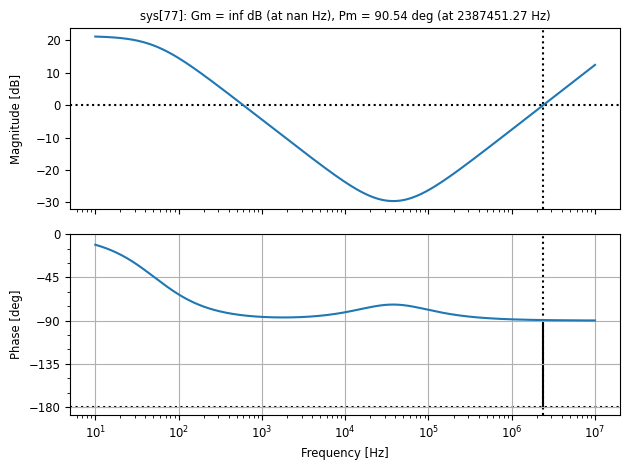

In [46]:
Rload = R_OUT  # 负载电阻 (Ohm)
C_out = 470e-6*2  # 实际输出电容 (F)

Nps = N_P / N_S  # 实际匝数比
Nt = 1 / Nps
Rsense = 1 / 5
Esr = 0.006
wz = 1 / Esr / C_out
print("fz = %.4f" % (wz/2/np.pi))
wrz = Rload * (1 - D_MAX ) * (1 - D_MAX ) / Nt / Nt / D_MAX  / L_P
print("frz = %.4f" % (wrz/2/np.pi))
wp = (1+D_MAX ) / Rload/C_out
Ak = 1 / 3
s = ctrl.TransferFunction.s
Gvv = (
    Ak
    * Rload
    * Nps
    * (1 - D_MAX )
    * (1 + s / wz)
    * (1 - s / wrz)
    / ((1 + D_MAX ) * Rsense * (1 + s / wp))
)

freq_Hz = np.logspace(1, 7, 1000)
omega = 2 * np.pi * freq_Hz

# 计算频率响应
mag, phase, omega = ctrl.frequency_response(Gvv, omega=omega)
mag_db = 20 * np.log10(mag)
phase_deg = np.degrees(phase)

# 查找所有0 dB穿越点
def find_zero_crossings(freq, mag_db):
    crossings = []
    for i in range(len(mag_db)-1):
        if mag_db[i] * mag_db[i+1] < 0:
            f_interp = interp1d(mag_db[i:i+2], freq[i:i+2], kind='linear')
            cross_freq = f_interp(0)
            crossings.append(cross_freq)
    return crossings

zero_crossings_Hz = find_zero_crossings(freq_Hz, mag_db)

# 计算相位裕度
phase_margins = []
for cross_freq_Hz in zero_crossings_Hz:
    idx = np.argmin(np.abs(freq_Hz - cross_freq_Hz))
    pm = phase_deg[idx] + 180
    phase_margins.append(pm)

# 输出结果
print("所有0 dB穿越点及其相位裕度:")
for freq, pm in zip(zero_crossings_Hz, phase_margins):
    print(f"穿越频率: {freq:.2f} Hz, 相位裕度: {pm:.2f}°")

# 绘制 Bode 图并显示稳定裕度
plt.figure()
ctrl.bode_plot(Gvv, omega=omega, dB=True, Hz=True, display_margins=True)
plt.grid(True)
plt.show()

由上图，有两个穿越点，3265.07 Hz和5910782.34 Hz，在高频段增益曲线上翘，是个不稳定系统

In [18]:
R_COM_P = 3000
C_COMP_P = 1/(2*np.pi*wz*R_COM_P)
print("C_COMP_P = %.4f pF" % (C_COMP_P*1e12))

C_COMP_P = 149.6056 pF


电压环补偿，将RCOMP假设为1000 Ohm，然后用之前计算的wz得出CCOMPP

In [19]:
#将上面的输出手动指定为实际值
# C_COMP_P = (300)*1e-12 # 反馈电容 (F)

In [20]:
R_FB = 1000
Gvp = R_COM_P/(R_FB*(1+s*R_COM_P*C_COMP_P))

|Gvv| at 20000.0 Hz = 0.06845535800704576
9841.93058769892


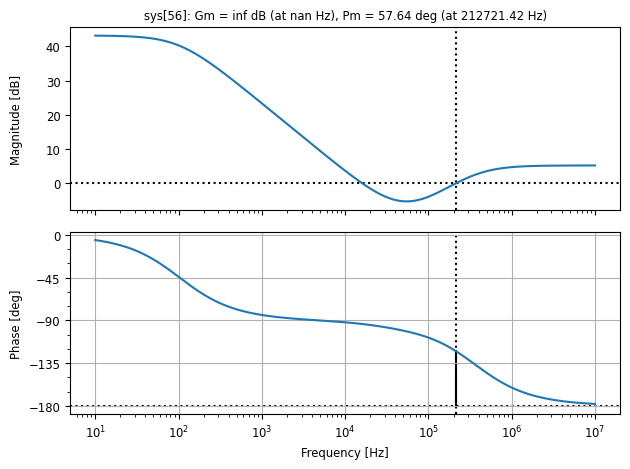

In [21]:
frequency = 20e3  # Hz
ss = 1j * 2 * np.pi * frequency
sss = 1 * I * 2 * np.pi * frequency
CTR = 0.5  # 光耦原副边电流比
R_pd = 1000  # 光耦副边下拉电阻
R_LED = symbols("R_LED", complex=True)  # 光耦LED电阻


# 代入传递函数公式
numerator = Ak * Rload * Nps * (1 - D_MAX) * (1 + ss / wz) * (1 - ss / wrz)
denominator = (1 + D_MAX) * Rsense * (1 + ss / wp)
Gvv_value = numerator / denominator

# 输出结果
magnitude = np.abs(Gvv_value)
print(f"|Gvv| at {frequency} Hz = {magnitude}")

Got_ = V_OUT * 1000 / R_LED * (1 + sss * 1000 * 0.1e-6 / (sss * 1000 * 0.1e-6))
Gvp_ = R_COM_P / (R_FB * (1 + sss * R_COM_P * C_COMP_P))
equation = Eq(Got_ * Gvp_, (1 / Gvv_value))
solution = solve(equation, R_LED)
print(np.abs(solution[0]))
R_LED_VALUE = np.abs(solution[0])
# R_LED_VALUE = 1.2e3

Got = V_OUT * 1000 / 11.7e3 * (1 + s * 1000 * 0.1e-6 / (s * 1000 * 0.1e-6))
Gvp = R_COM_P / (R_FB * (1 + s * R_COM_P * C_COMP_P))
Gs = Got * Gvp * Gvv
plt.figure()
ctrl.bode_plot(Gs, omega=omega, dB=True, Hz=True, display_margins=True)
plt.grid(True)
plt.show()


In [22]:
# 环路补偿输出
print("光耦及TL431参数：")
print("光耦LED电阻 R_LED = %.4f Ohm" % R_LED_VALUE)
print("光耦副边下拉电阻 R_pd = %.4f Ohm" % R_pd)
print("光耦原副边电流比 CTR = %.4f" % CTR)
print("反馈电阻 R_FB = %.4f Ohm" % R_FB)

print("UC4832参数：")
# print("补偿电容 C_COMP_P = %.4f pF" % (C_COMP_P * 1e12))
# print("补偿电阻 R_COM_P = %.4f Ohm" % R_COM_P)
print("补偿电阻 R_COM_P = %.4f kOhm" % (R_COM_P / 1000))
print("补偿电容 C_COMP_P = %.4f pF" % (C_COMP_P * 1e12))

光耦及TL431参数：
光耦LED电阻 R_LED = 9841.9306 Ohm
光耦副边下拉电阻 R_pd = 1000.0000 Ohm
光耦原副边电流比 CTR = 0.5000
反馈电阻 R_FB = 1000.0000 Ohm
UC4832参数：
补偿电阻 R_COM_P = 3.0000 kOhm
补偿电容 C_COMP_P = 149.6056 pF


In [23]:
f_BW = wrz/(2 * np.pi)/4
print("带宽 f_BW = %.4f kHz" % (f_BW/1e3))

带宽 f_BW = 12.7031 kHz
